In [5]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk

Load Data

In [6]:
def load_data(dir):
    data = []
    order = []
    for file in os.listdir(dir):
        if file.endswith(".csv"):
            print(os.path.join(dir, file))
            df = pd.read_csv(os.path.join(dir, file),on_bad_lines='skip')
            order.append(int(file[:-4]))
            if not df.empty:
                data.append(df)
    return data, order


try:
    Group1, Group1_order = load_data("/mnt/ArtHeart/Data/Group 1")
    Group2, Group2_order = load_data("/mnt/ArtHeart/Data/Group 2")
    Group3, Group3_order = load_data("/mnt/ArtHeart/Data/Group 3")
except:
    try:
        Group1, Group1_order = load_data("Data/Group 1")
        Group2, Group2_order = load_data("Data/Group 2")
        Group3, Group3_order = load_data("Data/Group 3")
    except:
        Group1, Group1_order = load_data("W:\PhD\ArtHeart\Data\Group 1")
        Group2, Group2_order = load_data("W:\PhD\ArtHeart\Data\Group 2")
        Group3, Group3_order = load_data("W:\PhD\ArtHeart\Data\Group 3")


W:\PhD\ArtHeart\Data\Group 1\1.csv
W:\PhD\ArtHeart\Data\Group 1\10.csv
W:\PhD\ArtHeart\Data\Group 1\11.csv
W:\PhD\ArtHeart\Data\Group 1\12.csv
W:\PhD\ArtHeart\Data\Group 1\13.csv
W:\PhD\ArtHeart\Data\Group 1\14.csv
W:\PhD\ArtHeart\Data\Group 1\15.csv
W:\PhD\ArtHeart\Data\Group 1\16.csv
W:\PhD\ArtHeart\Data\Group 1\17.csv
W:\PhD\ArtHeart\Data\Group 1\18.csv
W:\PhD\ArtHeart\Data\Group 1\19.csv
W:\PhD\ArtHeart\Data\Group 1\2.csv
W:\PhD\ArtHeart\Data\Group 1\20.csv
W:\PhD\ArtHeart\Data\Group 1\21.csv
W:\PhD\ArtHeart\Data\Group 1\22.csv
W:\PhD\ArtHeart\Data\Group 1\23.csv
W:\PhD\ArtHeart\Data\Group 1\24.csv
W:\PhD\ArtHeart\Data\Group 1\25.csv
W:\PhD\ArtHeart\Data\Group 1\26.csv
W:\PhD\ArtHeart\Data\Group 1\27.csv
W:\PhD\ArtHeart\Data\Group 1\28.csv
W:\PhD\ArtHeart\Data\Group 1\29.csv
W:\PhD\ArtHeart\Data\Group 1\3.csv
W:\PhD\ArtHeart\Data\Group 1\30.csv
W:\PhD\ArtHeart\Data\Group 1\31.csv
W:\PhD\ArtHeart\Data\Group 1\32.csv
W:\PhD\ArtHeart\Data\Group 1\33.csv
W:\PhD\ArtHeart\Data\Group 1\34

In [7]:
def interpolate_nan(data):
    for i in range(len(data)):
        df = data[i]
        df['UTC'] = df['UTC'].interpolate()
        data[i] = df
    return data


def cut_to_common_length(data):

    # Interpolate NaN values
    data = interpolate_nan(data)

    # Find the shortest dataframe
    shortest_df = min(data, key=lambda x: len(x))

    # Find the first value of UTC in the shortest dataframe that isn't NaN
    first_utc = shortest_df['UTC'].first_valid_index()
    first_utc_value = shortest_df['UTC'][first_utc]

    # Find the length of the dataframe from that point to the end
    length = len(shortest_df.loc[first_utc:])

    # Cut all dataframes to the same length and reset the index
    for i in range(len(data)):
        df = data[i]

        if first_utc_value in df['UTC'].values:
            match_utc_index = df[df['UTC'] == first_utc_value].index[0]
        else:
            match_utc_index = df.iloc[(df['UTC']-first_utc_value).abs().argsort()[:1]].index[0]

        df = df.loc[match_utc_index:].iloc[:length].reset_index(drop=True)
        data[i] = df
    return data




Group1 = cut_to_common_length(Group1)
Group2 = cut_to_common_length(Group2)
Group3 = cut_to_common_length(Group3)
 
sample_rate = 24

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


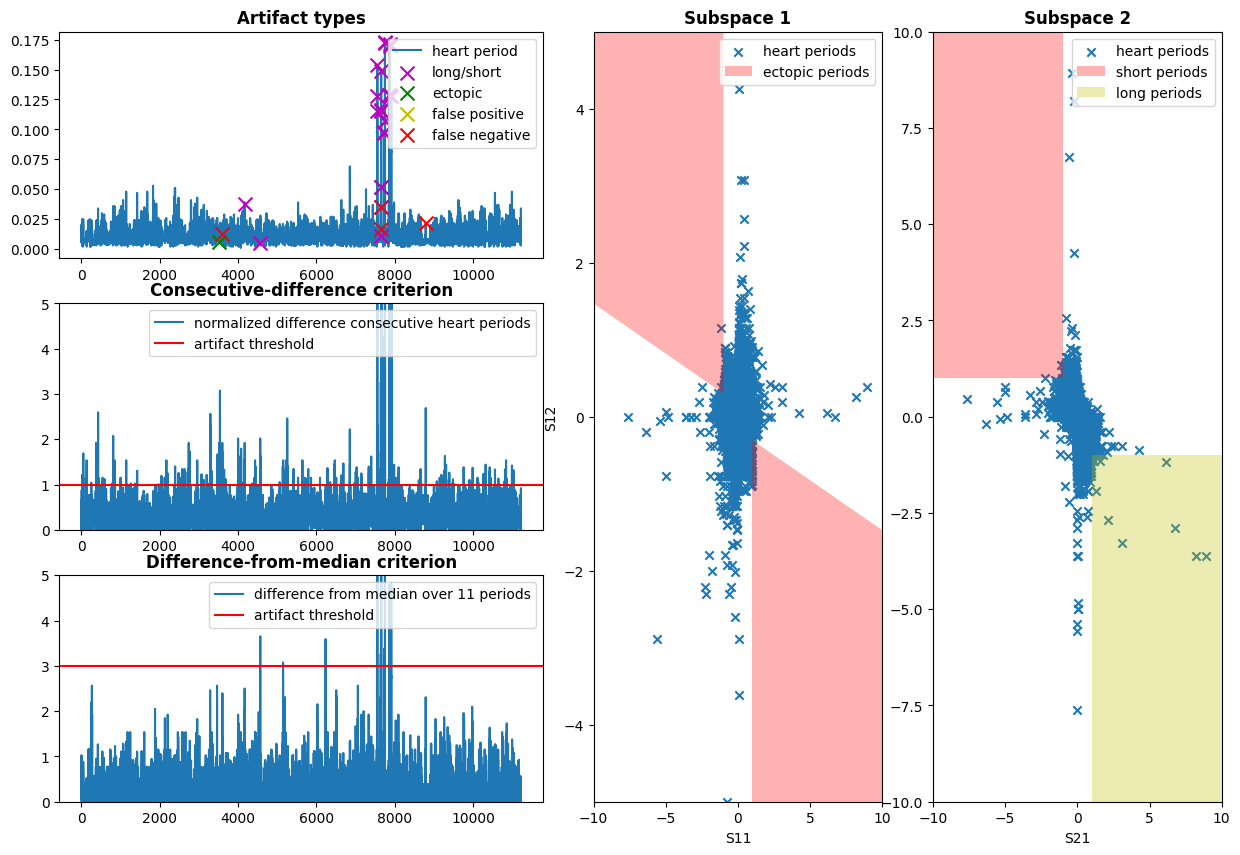

In [8]:
rpeaks_uncorrected  = nk.signal_findpeaks(Group1[0]['DATA'])
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\signal\signal_plot.py:175: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if sampling_rate is None and signal.index.is_integer():


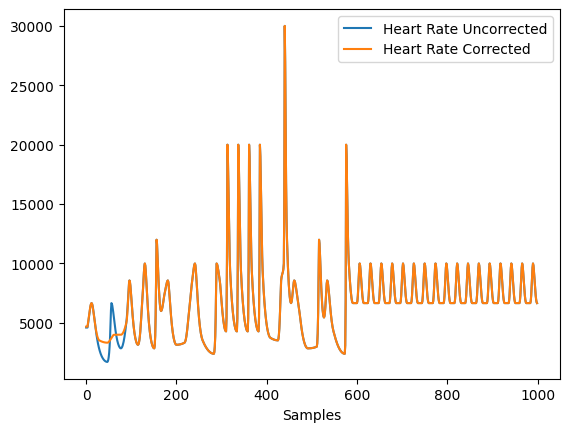

In [9]:
rate_corrected = nk.signal_rate(rpeaks_corrected, desired_length=len(Group1[0]['DATA']))

rate_uncorrected = nk.signal_rate(rpeaks_uncorrected, desired_length=len(Group1[0]['DATA']))

nk.signal_plot(
    [rate_uncorrected[:1000], rate_corrected[:1000]],
    labels=["Heart Rate Uncorrected", "Heart Rate Corrected"]
)

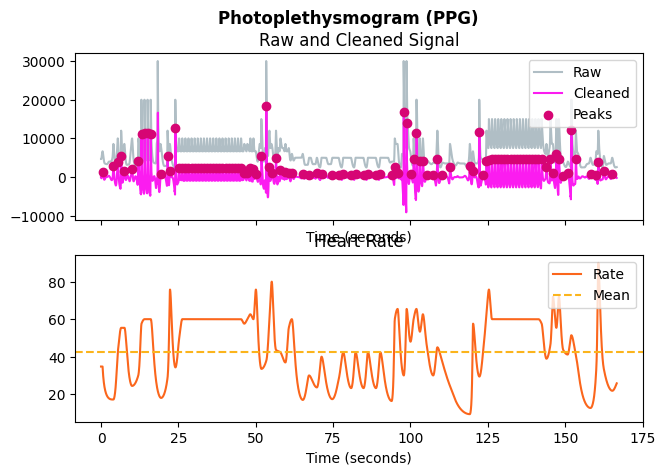

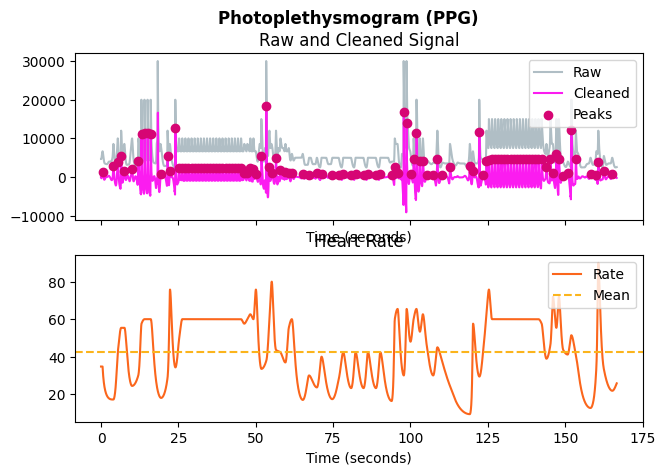

In [10]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals[:4000], sampling_rate=24)

In [11]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=sample_rate)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN   HRV_SDANN1  HRV_SDNNI1  \
0      37.200808  1727.100154  2773.934585  1130.849059  2668.24222   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5   HRV_RMSSD  ...  \
0   460.44691  2626.137474  343.242177  2676.152834  3805.40222  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.329139    4.702036     0.413515  0.290254   0.556601    0.450076   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.175638  1.950908  2.224295  0.701931  

[1 rows x 90 columns]


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])


So it looks like the bad sections in the data are affecting the average calculations so now we will cut them out and do the analysis again

In [12]:
def cut_bad_data(raw, windowsize = 100):
    mx = np.max(raw)
    mn = np.min(raw)
    global_range = mx - mn
    
    filtered = []
    
    for i in range(len(raw) // windowsize):
        start = i * windowsize
        end = (i + 1) * windowsize
        sliced = raw[start:end]
        rng = np.max(sliced) - np.min(sliced)
        
        if ((rng >= (0.5 * global_range)) 
            or 
            (np.max(sliced) >= 0.9 * mx) 
            or 
            (np.min(sliced) <= mn + (0.1 * mn))):
            
            for x in sliced:
                filtered.append(np.nan)
        else:
            for x in sliced:
                filtered.append(x)
                
    filtered = np.array(filtered)
    filtered = filtered[~np.isnan(filtered)]
    return filtered

data = Group1[0]['DATA']
data = cut_bad_data(data)

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


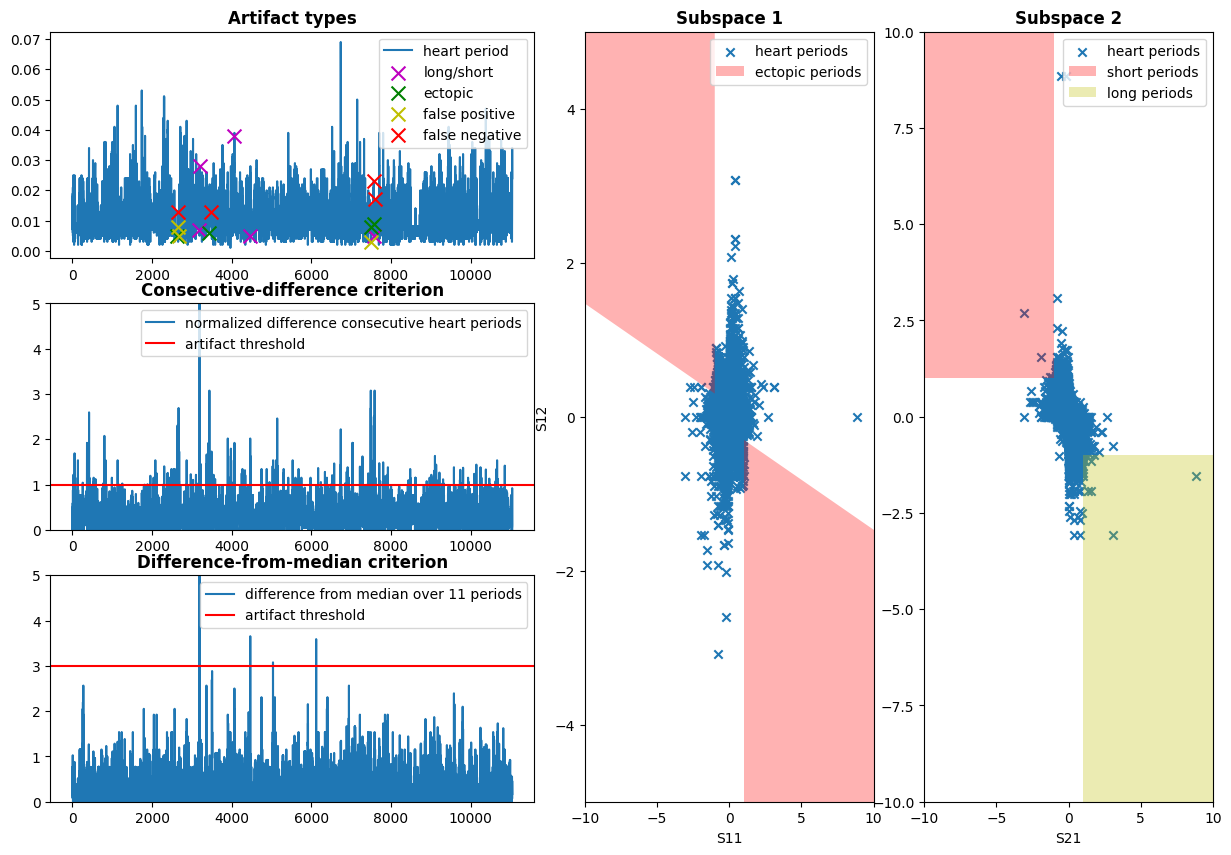

In [13]:
rpeaks_uncorrected  = nk.signal_findpeaks(data)
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\signal\signal_plot.py:175: FutureWarning: RangeIndex.is_integer is deprecated. Use pandas.api.types.is_integer_dtype instead.
  if sampling_rate is None and signal.index.is_integer():


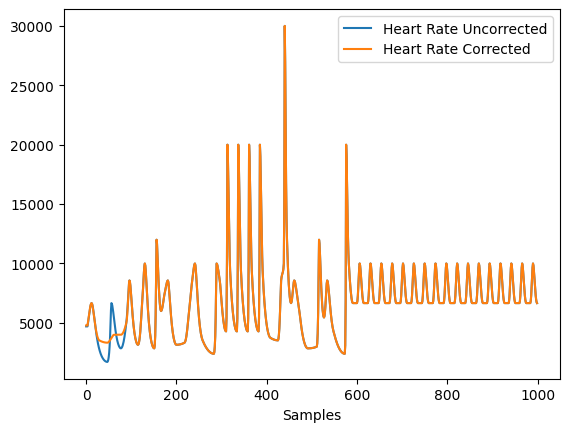

In [14]:
rate_corrected = nk.signal_rate(rpeaks_corrected, desired_length=len(Group1[0]['DATA']))

rate_uncorrected = nk.signal_rate(rpeaks_uncorrected, desired_length=len(Group1[0]['DATA']))

nk.signal_plot(
    [rate_uncorrected[:1000], rate_corrected[:1000]],
    labels=["Heart Rate Uncorrected", "Heart Rate Corrected"]
)

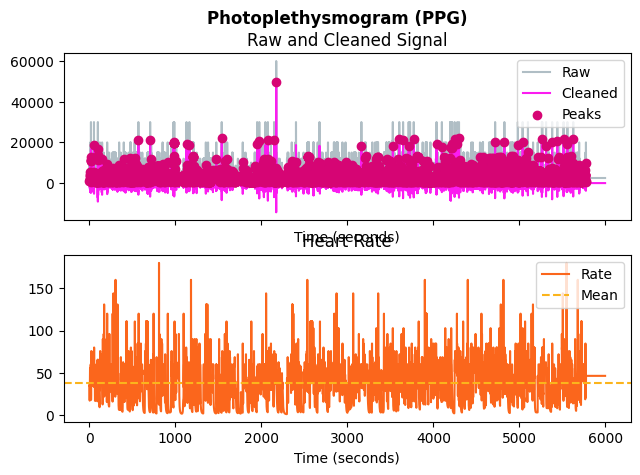

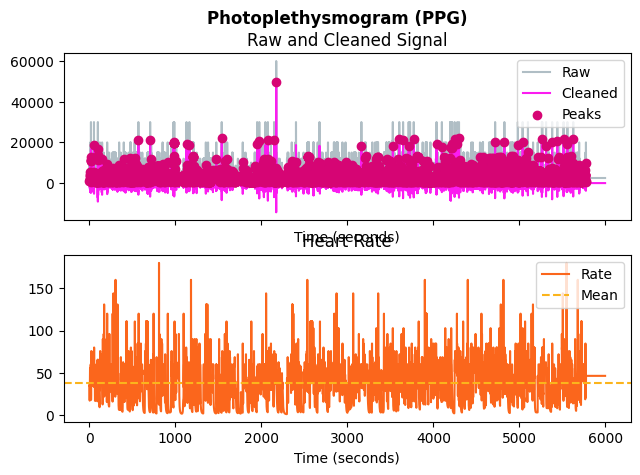

In [15]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [16]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      38.061754  1696.918479  2664.042897  988.515907  2428.485429   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0   689.70991  2473.573076  356.759018  2551.928587  3635.632897  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.338698    4.674915     0.415427  0.288483   0.595738    0.483475   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.174681  1.945344  2.188382  0.686273  

[1 rows x 90 columns]


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])


Again not much changed. now I will try removing baseline wander, scaling and filtering along with the removal of bad sections 

In [17]:
import heartpy as hp

def remove_baseline_wander(data):
    data = hp.remove_baseline_wander(data, sample_rate=24)
    data = hp.filter_signal(data, cutoff=[0.7, 3.5], sample_rate=24, order=3, filtertype='bandpass')
    return data

data = cut_bad_data(Group1[0]['DATA'])
data = remove_baseline_wander(data)


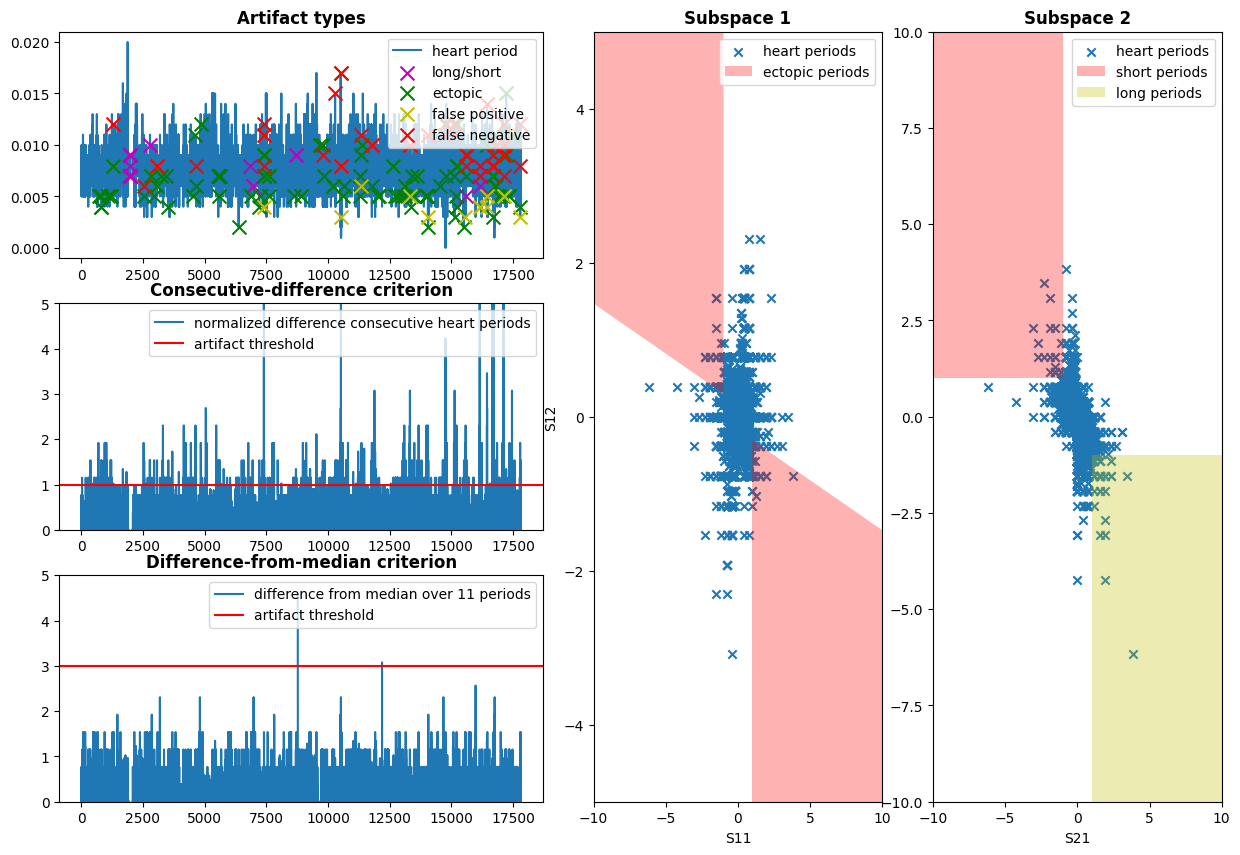

In [18]:
rpeaks_uncorrected  = nk.signal_findpeaks(data)
artifacts, rpeaks_corrected = nk.signal_fixpeaks(rpeaks_uncorrected, iterative=True, show=True)

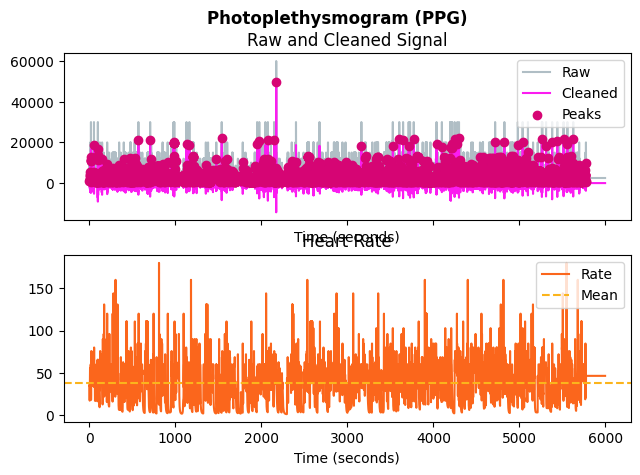

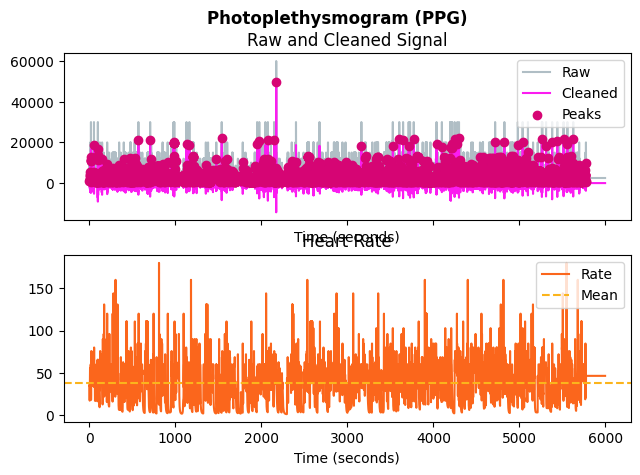

In [19]:
signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [20]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      38.061754  1696.918479  2664.042897  988.515907  2428.485429   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0   689.70991  2473.573076  356.759018  2551.928587  3635.632897  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.338698    4.674915     0.415427  0.288483   0.595738    0.483475   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.174681  1.945344  2.188382  0.686273  

[1 rows x 90 columns]


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])


Still not accurate. I will try using a different package for the ppg processing and see if that works

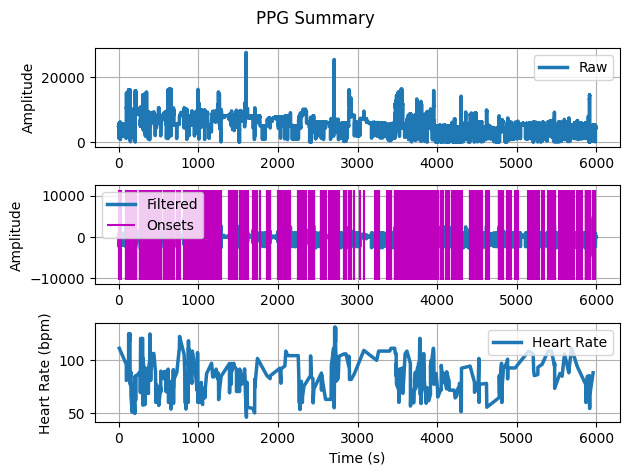

Median HR: 82.43377674956622 bpm


In [21]:
from biosppy.signals import ppg 
data = Group1[0]['DATA']
data = ppg.ppg(signal=data, sampling_rate=24.0, show=True)
median_hr = np.median(data[4])
print("Median HR: "+ str(median_hr) + " bpm")

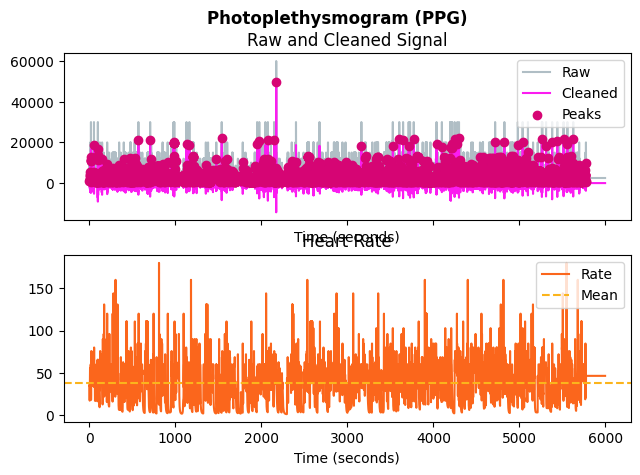

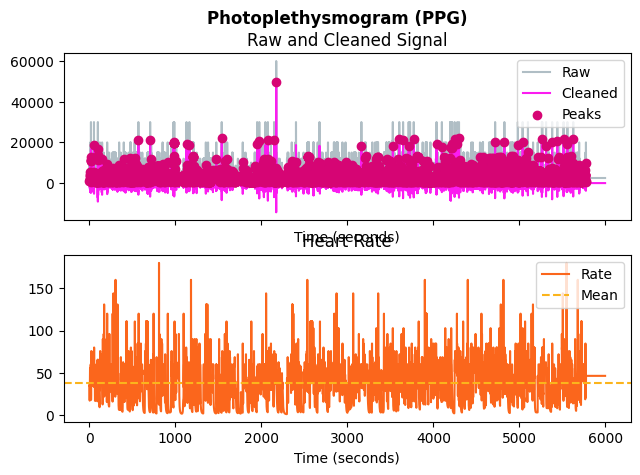

In [22]:
data = data[1]

signals, info = nk.ppg_process(rate_corrected, sampling_rate=24)
nk.ppg_plot(signals, sampling_rate=24)

In [23]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

   PPG_Rate_Mean   HRV_MeanNN     HRV_SDNN  HRV_SDANN1   HRV_SDNNI1  \
0      38.061754  1696.918479  2664.042897  988.515907  2428.485429   

   HRV_SDANN2   HRV_SDNNI2  HRV_SDANN5   HRV_SDNNI5    HRV_RMSSD  ...  \
0   689.70991  2473.573076  356.759018  2551.928587  3635.632897  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.338698    4.674915     0.415427  0.288483   0.595738    0.483475   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.174681  1.945344  2.188382  0.686273  

[1 rows x 90 columns]


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])


well thats not ideal... lets build our own process function based on biosppy since it gives a realistic Median HR

In [24]:
def match_interpolate_hr(time,hr_time,hr):
    inter_hr = np.nan*np.ones(len(time)) # initialize interpolated hr array
    
    for i in range(len(hr_time)):
        j = hr_time[i]
        # find index of time that is closest in time to i
        idx = np.argmin(np.abs(time-j))
        inter_hr[int(idx)] = hr[i]
    
    # interpolate missing values

    inter_hr = pd.DataFrame(columns=['hr'], data=inter_hr)
    if pd.isnull(inter_hr['hr'][0]):
        inter_hr['hr'][0] = hr[0]
    inter_hr = inter_hr.interpolate(method='linear')
    inter_hr = inter_hr.values.flatten()
    return inter_hr


def custom_process(data, sample_rate=24):
    clean_data = ppg.ppg(signal=data, sampling_rate=sample_rate, show=False)
    
    raw = data.values
    clean_sig = clean_data[1]
    time = clean_data[0]
    
    
    
    heart_rate = clean_data[4]
    heart_rate_ts = clean_data[3]
    
    hr = match_interpolate_hr(time,heart_rate_ts,heart_rate)
    quality = nk.ecg_quality(clean_sig, sampling_rate=sample_rate)

    # find ppg_peaks by making np array of zeros of length of clean_sig and then set 1 to the values of clean_data[2]
    ppg_peaks = np.zeros(len(clean_sig))
    ppg_peaks[clean_data[2]] = 1
    
    signals = pd.DataFrame({"PPG_Raw": np.array(raw),
                            "PPG_Clean": np.array(clean_sig),
                            "PPG_Peaks": ppg_peaks,
                            "PPG_Rate": np.array(hr),
                            "PPG_Quality": quality})
    
    return signals


signals = custom_process(Group1[0]['DATA'], sample_rate=24)


    


In [25]:
analyze_df = nk.ppg_analyze(signals, sampling_rate=24)
print(analyze_df)

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\hrv\hrv_time.py:227: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


   PPG_Rate_Mean  HRV_MeanNN     HRV_SDNN    HRV_SDANN1   HRV_SDNNI1  \
0      87.483526   5594.5198  13577.80518  16761.029689  13229.63845   

     HRV_SDANN2    HRV_SDNNI2   HRV_SDANN5    HRV_SDNNI5    HRV_RMSSD  ...  \
0  15879.392972  16492.329348  7856.906804  15623.031165  18953.07351  ...   

   HRV_SampEn  HRV_ShanEn  HRV_FuzzyEn  HRV_MSEn  HRV_CMSEn  HRV_RCMSEn  \
0    0.379091    5.963152     0.475595  0.681925   0.568089    0.441984   

     HRV_CD   HRV_HFD   HRV_KFD   HRV_LZC  
0  0.354361  2.013683  2.488159  0.677706  

[1 rows x 90 columns]


c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])


Bit Bodged but it has more realistic HRV values. I will try to use this on the whole dataset and see if it works with ML

In [26]:
def process_data(data):
    processed_data = []
    for i in range(len(data)):
        processed_data.append(nk.ppg_analyze(custom_process(data[i]['DATA'], sample_rate=24), sampling_rate=24))
    return processed_data

Group1_processed = process_data(Group1)
Group2_processed = process_data(Group2)
Group3_processed = process_data(Group3)



c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\hrv\hrv_time.py:227: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\ppg\ppg_intervalrelated.py:133: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  output[column] = float(results[column])
c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\neurokit2\hrv\hrv_time.py:227: RuntimeWarning: Mean of empty slice
  avg_rri.append(np.nanmean(rri[start_idx:end_idx]))
c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\numpy\lib\nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out,

c:\Users\Tom\.conda\envs\tfconda\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


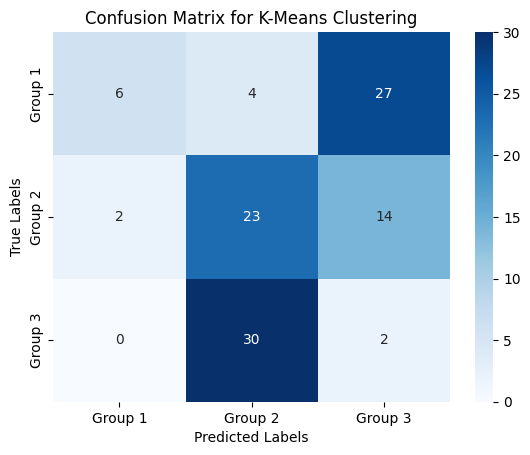

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Combine all the processed data into a single array
all_data = np.concatenate([Group1_processed, Group2_processed, Group3_processed])

# Reshape the data into a 2D array with 90 features
X = all_data.reshape(-1, 90)

# Perform k-means clustering with 3 classes
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_



# Create a confusion matrix to compare the predicted labels with the actual group numbers
actual_labels = np.concatenate([np.zeros(len(Group1_processed)), np.ones(len(Group2_processed)), np.full(len(Group3_processed), 2)])
conf_matrix = confusion_matrix(actual_labels, labels)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=["Group 1", "Group 2", "Group 3"], yticklabels=["Group 1", "Group 2", "Group 3"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix for K-Means Clustering")
plt.show()

Now lets load the scores for the data groups and make 3 groups from them (not engaged, medium engagement, high engagement)

In [32]:
Group1_scores = []
Group2_scores = []
Group3_scores = []

def emotion_definer(emotions):
    emotions = emotions.split(";")
    emotions = [x.strip(' ') for x in emotions]
    valence_score = []
    arousal_score = []
    for emotion in emotions:
        emotion = emotion.lower()
        if emotion == 'happy' or emotion == 'immersed':
            valence_score.append(1)
            arousal_score.append(0)
        elif emotion == 'sad':
            valence_score.append(-1)
            arousal_score.append(0)
        elif emotion == 'angry':
            valence_score.append(-0.5)
            arousal_score.append(1)
        elif emotion == 'tense' or emotion == 'confused':
            valence_score.append(-0.25)
            arousal_score.append(1)
        elif emotion == 'relaxed' or emotion == 'intrigued' or emotion == 'interest':
            valence_score.append(0.5)
            arousal_score.append(-1)
        elif emotion == 'excited' or emotion == 'hypedup':
            valence_score.append(0.5)
            arousal_score.append(1)
        elif emotion == 'delighted':
            valence_score.append(1)
            arousal_score.append(1)
        elif emotion == 'bored':
            valence_score.append(-1)
            arousal_score.append(-1)
        elif emotion == 'content':
            valence_score.append(1)
            arousal_score.append(-0.25)
        elif emotion == 'calm':
            valence_score.append(0)
            arousal_score.append(-1)
        elif emotion == 'sleepy' or emotion == 'tired':
            valence_score.append(0)
            arousal_score.append(-1)
        elif emotion == 'nervous' or emotion == 'anxious' or emotion == 'scared':
            valence_score.append(-1)
            arousal_score.append(0.25)
        elif emotion == 'alright' or emotion == 'fine' or emotion == 'other':
            valence_score.append(0)
            arousal_score.append(0)
        
    return (np.mean(valence_score), np.mean(arousal_score))
        
        
        
    
def load_Scores(location):
    if "xlsx" in location:
        data = pd.read_excel(location)
    elif "csv" in location:
        data = pd.read_csv(location)


    if "How would you rate this performance?" in data.columns:
        order = data["Watch ID"]
        scores = data["How would you rate this performance?"]
    elif "How did you rate the performance?" in data.columns:
        order = data["Watch ID"]
        scores  = data["How did you rate the performance?"]
    elif "How would you rate this performance?（10 is the best）" in data.columns:
        order = data["ID"]
        scores  = data["How would you rate this performance?（10 is the best）"]

    if "How would you describe your feelings through the performance?" in data.columns:
        emotions = data["How would you describe your feelings through the performance?"]
    elif "How do you describe your feeling during the programme? You may make multiple choices." in data.columns:
        emotions = data["How do you describe your feeling during the programme? You may make multiple choices."]
        
    emotions = emotions.apply(emotion_definer)
        
    return scores, order, emotions




try:
    Group1_scores, Group1_scores_order, Group1_emotions = load_Scores("/mnt/ArtHeart/Data/Group 1 Scores.xlsx")
    Group2_scores,Group2_scores_order, Group2_emotions = load_Scores("/mnt/ArtHeart/Data/Group 2 Scores.xlsx")
    Group3_scores,Group3_scores_order, Group3_emotions = load_Scores("/mnt/ArtHeart/Data/Group 3 Scores.csv")
except:
    try:
        Group1_scores, Group1_scores_order, Group1_emotions = load_Scores("W:\PhD\ArtHeart\Data\Group 1 Scores.xlsx")
        Group2_scores,Group2_scores_order, Group2_emotions = load_Scores("W:\PhD\ArtHeart\Data\Group 2 Scores.xlsx")
        Group3_scores,Group3_scores_order, Group3_emotions = load_Scores("W:\PhD\ArtHeart\Data\Group 3 Scores.csv")

    except:
        Group1_scores, Group1_scores_order, Group1_emotions = load_Scores("Data/Group 1 Scores.xlsx")
        Group2_scores,Group2_scores_order, Group2_emotions = load_Scores("Data/Group 2 Scores.xlsx")
        Group3_scores,Group3_scores_order, Group3_emotions = load_Scores("Data/Group 3 Scores.csv")


def match_scores_to_data(scores, scores_order, emotions, data, data_order):
    matched_scores = []
    matched_data = []
    matched_emotions = []

    # Zip the scores and order and the data and data order
    scores_zip = zip(scores_order, scores, emotions)
    data_zip = zip(data_order, data)

    # Sort the zipped lists by order
    scores_zip = sorted(scores_zip, key=lambda x: x[0])
    data_zip = sorted(data_zip, key=lambda x: x[0])

    # Unzip the sorted lists
    sorted_scores_order, sorted_scores = zip(*scores_zip)
    sorted_data_order, sorted_data = zip(*data_zip)

    # Match the scores to the data using the order of each
    for i in range(min(len(sorted_scores_order), len(sorted_data_order))):
        if sorted_scores_order[i] == sorted_data_order[i]:
            matched_scores.append(sorted_scores[i])
            matched_data.append(sorted_data[i])
            matched_emotions.append(emotions[i])
    return matched_scores, matched_data, matched_emotions

Group1_scores, Group1_processed, Group1_emotions = match_scores_to_data(Group1_scores, Group1_scores_order, Group1_processed, Group1_order)
Group2_scores, Group2_processed, Group2_emotions = match_scores_to_data(Group2_scores, Group2_scores_order, Group2_processed, Group2_order)
Group3_scores, Group3_processed, Group3_emotions = match_scores_to_data(Group3_scores, Group3_scores_order, Group3_processed, Group3_order)


UnboundLocalError: cannot access local variable 'emotions' where it is not associated with a value

In [ ]:
from sklearn.preprocessing import StandardScaler

def three_score_calc(score):
    mean = np.mean(score)
    std = np.std(score)
    score[score < mean - std] = 0
    score[(score >= mean - std) & (score <= mean + std)] = 1
    score[score > mean + std] = 2
    return score

def binary_score_calc(score):
    mean = np.mean(score)
    std = np.std(score)
    score[score < mean - std] = 0
    score[score >= mean - std] = 1
    return score
    
def three_score_detection(scores, emotions):
    scores = np.array(scores)
    scale = StandardScaler()
    scores = scale.fit_transform(scores.reshape(-1, 1))
    valence = np.array(emotions[:, 0])
    arousal = np.array(emotions[:, 1])
    
    valence = [a*b for a,b in zip(scores, valence)]
    arousal = [a*b for a,b in zip(scores, arousal)]
    
    valence = three_score_calc(valence)
    arousal = three_score_calc(arousal)
    return valence , arousal

def binary_score_detection(scores, emotions):
    scores = np.array(scores)
    scale = StandardScaler()
    scores = scale.fit_transform(scores.reshape(-1, 1))
    valence = np.array(emotions[:, 0])
    arousal = np.array(emotions[:, 1])
    valence = [a*b for a,b in zip(scores, valence)]
    arousal = [a*b for a,b in zip(scores, arousal)]
    
    valence = binary_score_calc(valence)
    arousal = binary_score_calc(arousal)
    return valence , arousal

Group1_three_valence, Group1_three_arousal = three_score_detection(Group1_scores, Group1_emotions)
Group2_three_valence, Group2_three_arousal = three_score_detection(Group2_scores, Group2_emotions)
Group3_three_valence, Group3_three_arousal = three_score_detection(Group3_scores, Group3_emotions)

Group1_binary_valence, Group1_binary_arousal  = binary_score_detection(Group1_scores, Group1_emotions)
Group2_binary_valence, Group2_binary_arousal = binary_score_detection(Group2_scores, Group2_emotions)
Group3_binary_valence, Group3_binary_arousal = binary_score_detection(Group3_scores, Group3_emotions)

print(len(Group1_processed), len(Group1_three_valence))
print(len(Group2_processed), len(Group2_three_valence))
print(len(Group3_processed), len(Group3_three_valence))


Its not bad! Gets Group1 & 2 clustered very well but Group 3 not too good. Next lets try some other ML methods 